<div style="display:flex; flex-direction:row; justify-content:space-between">
    <a href="./2_UnivariateForecast.ipynb" target="_blank">Univariate Forecast</a>
    <a href="./README.md" target="_blank">Project Overview</a>
</div>

--- 

# Multivariate Forecast

---

📌 In this notebook, **all** stock ticker and search trend variables are utilized as the model data.

📑 Dataset Used: [BTC-SearchTrend.csv](./data/BTC-SearchTrend.csv)

In [ ]:
#@title Basic Libaries { run: "auto" }
#@markdown Getting started with the essential libraries

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
sb.set(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rcParams["figure.figsize"] = (40,10)

# Add-on preferences
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings as wn
wn.simplefilter(action="ignore", category=FutureWarning)

from copy import deepcopy

In [ ]:
#@title Global Attributes { run: "auto" }
#@markdown Define environment states

onDrive = False #@param {type:"boolean"}

try:
  import google.colab
  onColab = True

  from google.colab import files
  
  if onDrive:
    from google.colab import drive
    drive.mount('drive')
except ImportError or ModuleNotFoundError:
  onColab = False
  onDrive = False

print(f"Using Google Colab: {onColab}");
print(f"Using Google Drive: {onDrive}");

Using Google Colab: True
Using Google Drive: False


### Set Coin Ticker
*Define the ticker in the data*

In [ ]:
coinSymbols = 'BTC' #@param ["BTC", "ETH"]{allow-input: true}

# List crypto tickers
coins = [coinSymbols]
coinTickers = [f"{c}-USD" for c in coins]

coinTicker = coinTickers[0]

coinTicker

'BTC-USD'

### Data Import

In [ ]:
fileName = f"{coinTicker.split('-')[0]}-SearchTrend.csv"
importFolderPath = "data" #@param {type:"string"}
if len(importFolderPath) > 0 and not importFolderPath.endswith('/'):
  importFolderPath += '/'

if onColab:
  if onDrive:
    importFolderPath = f'/content/drive/My Drive/{importFolderPath if len(importFolderPath) > 0 else ""}'
  else:
    importFolderPath = f"/content/{importFolderPath if len(importFolderPath) > 0 else ''}"
else:
  BASE_DIR = os.getcwd()
  importFolderPath = os.path.join(BASE_DIR, f"{importFolderPath if len(importFolderPath) > 0 else ''}")
filePath = f'{importFolderPath}{fileName}'

# Import CSV 
try:
  rawData = pd.read_csv(filePath, header=0, index_col=0)
  rawData.index = pd.to_datetime(rawData.index)

  # Preview data
  rawData.head()
  rawData.shape
except FileNotFoundError:
    print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY
DATE,,,,,,,
2017-01-01,963.66,"1,003.08",958.70,998.33,147775008,37.00,18.00
2017-01-02,998.62,"1,031.39",996.70,"1,021.75",222184992,61.00,27.00
2017-01-03,"1,021.60","1,044.08","1,021.60","1,043.84",185168000,59.00,34.00
2017-01-04,"1,044.40","1,159.42","1,044.40","1,154.73",344945984,66.00,32.00
2017-01-05,"1,156.73","1,191.10",910.42,"1,013.38",510199008,82.00,34.00


(1936, 7)

## Data Preprocess

---

### Data Overview

In [ ]:
print(f"{'- '*15} INFO {'- '*15}\n")
rawData.info()

print(f"{'- '*15} DESCRIBE {'- '*15}\n")
rawData.describe()

- - - - - - - - - - - - - - -  INFO - - - - - - - - - - - - - - - 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1936 entries, 2017-01-01 to 2022-04-20
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPEN            1936 non-null   float64
 1   HIGH            1936 non-null   float64
 2   LOW             1936 non-null   float64
 3   CLOSE           1936 non-null   float64
 4   VOLUME          1936 non-null   int64  
 5   BITCOIN         1936 non-null   float64
 6   CRYPTOCURRENCY  1936 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 121.0 KB
- - - - - - - - - - - - - - -  DESCRIBE - - - - - - - - - - - - - - - 



,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY
count,"1,936.00","1,936.00","1,936.00","1,936.00","1,936.00","1,936.00","1,936.00"
mean,"16,962.48","17,412.21","16,468.55","16,981.24","21,413,205,923.24",63.17,47.43
std,"17,578.72","18,036.64","17,051.36","17,579.51","20,728,747,158.38",13.53,11.85
min,775.18,823.31,755.76,777.76,"60,851,700.00",7.00,11.00
25%,"5,937.57","6,191.92","5,774.10","5,974.36","4,835,379,100.25",56.00,40.00
50%,"8,939.35","9,201.87","8,788.03","8,964.93","17,504,715,049.50",66.00,48.00
75%,"23,539.23","24,066.45","22,808.60","23,747.72","32,510,444,835.50",73.00,56.00
max,"67,549.73","68,789.62","66,382.06","67,566.83","350,967,941,479.00",91.00,80.00


### Data Screening
*Check for null values*

In [ ]:
print('NULL values:',rawData.isnull().values.sum())
print('NA values:',rawData.isnull().values.any())
print('SHAPE:',rawData.shape)

NULL values: 0
NA values: False
SHAPE: (1936, 7)


## Models

---

In [ ]:
#@title Add-on Libaries { run: "auto" }

if onColab:
  !{sys.executable} -m pip install -q plotly sklearn tensorflow

import plotly.express as px
# from plotly.offline import plot, iplot, init_notebook_mode
# init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score, confusion_matrix, f1_score

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

from math import sqrt

### Model Data Extraction
*Store a copy of the dataset*

In [ ]:
data = deepcopy(rawData)
# Filter out predictor columns (Search Terms)
tickerCols = ['Open','High','Low','Close','Volume']
searchCols = list(set(rawData.columns)-set(t.upper() for t in tickerCols))
searchColIdx = [rawData.columns.get_loc(col) for col in searchCols]

# response = 'CLOSE' #@param ["CLOSE", "OPEN", "HIGH", "LOW"]{allow-input: true}
# mainData = deepcopy(rawData)[[response]][rawData.index >= f'{rawData.iloc[-1].name.year - 2}-01-01']

# mainData = deepcopy(rawData)[rawData.index >= f'{rawData.iloc[-1].name.year - 2}-01-01']
mainData = deepcopy(rawData)

mainData.tail()
mainData.shape

,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY
DATE,,,,,,,
2022-04-16,"40,552.32","40,633.68","40,078.43","40,424.48",16833150693,72.00,54.00
2022-04-17,"40,417.78","40,570.73","39,620.89","39,716.95",19087633042,73.00,54.00
2022-04-18,"39,721.20","40,986.32","38,696.19","40,826.21",33705182072,88.00,65.00
2022-04-19,"40,828.18","41,672.96","40,618.63","41,502.75",25303206547,84.00,55.00
2022-04-20,"41,453.36","41,833.21","41,282.08","41,833.21",26641080320,75.00,54.00


(1936, 7)

### LSTM
---

📌 [Long Short-Term Memory (LSTM)](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/) models are a type of recurrent neural network capable of learning sequences of observations. This makes them a deep learning network well suited for time series forecasting.

*References*
* [Multi-Step LSTM Time Series Forecasting Models](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)


#### Normalisation
*Dataset values are normalized by using MinMax method.*

In [ ]:
data = deepcopy(mainData)

scaler = MinMaxScaler(feature_range=(0,1))
scaledData = scaler.fit_transform(data)

# Preview dataset
pd.concat([data.reset_index(), pd.DataFrame(scaledData, columns = [f"SCALED-{c}" for c in rawData.columns])], axis=1)

,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY,SCALED-OPEN,SCALED-HIGH,SCALED-LOW,SCALED-CLOSE,SCALED-VOLUME,SCALED-BITCOIN,SCALED-CRYPTOCURRENCY
0,2017-01-01,963.66,"1,003.08",958.70,998.33,147775008,37.00,18.00,0.00,0.00,0.00,0.00,0.00,0.36,0.10
1,2017-01-02,998.62,"1,031.39",996.70,"1,021.75",222184992,61.00,27.00,0.00,0.00,0.00,0.00,0.00,0.64,0.23
2,2017-01-03,"1,021.60","1,044.08","1,021.60","1,043.84",185168000,59.00,34.00,0.00,0.00,0.00,0.00,0.00,0.62,0.33
3,2017-01-04,"1,044.40","1,159.42","1,044.40","1,154.73",344945984,66.00,32.00,0.00,0.00,0.00,0.01,0.00,0.70,0.30
4,2017-01-05,"1,156.73","1,191.10",910.42,"1,013.38",510199008,82.00,34.00,0.01,0.01,0.00,0.00,0.00,0.89,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,2022-04-16,"40,552.32","40,633.68","40,078.43","40,424.48",16833150693,72.00,54.00,0.60,0.59,0.60,0.59,0.05,0.77,0.62
1932,2022-04-17,"40,417.78","40,570.73","39,620.89","39,716.95",19087633042,73.00,54.00,0.59,0.58,0.59,0.58,0.05,0.79,0.62
1933,2022-04-18,"39,721.20","40,986.32","38,696.19","40,826.21",33705182072,88.00,65.00,0.58,0.59,0.58,0.60,0.10,0.96,0.78
1934,2022-04-19,"40,828.18","41,672.96","40,618.63","41,502.75",25303206547,84.00,55.00,0.60,0.60,0.61,0.61,0.07,0.92,0.64


#### Reframe
*Normalized values are converted for supervised learning.*

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Normalized values are converted for supervised learning 
reframedData = deepcopy(scaledData) 
reframedData = series_to_supervised(reframedData,1,1)
reframedData.tail()
print(f"Reframed Data : {reframedData.shape}")

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1931,0.59,0.59,0.60,0.60,0.06,0.60,0.55,0.60,0.59,0.60,0.59,0.05,0.77,0.62
1932,0.60,0.59,0.60,0.59,0.05,0.77,0.62,0.59,0.58,0.59,0.58,0.05,0.79,0.62
1933,0.59,0.58,0.59,0.58,0.05,0.79,0.62,0.58,0.59,0.58,0.60,0.10,0.96,0.78
1934,0.58,0.59,0.58,0.60,0.10,0.96,0.78,0.60,0.60,0.61,0.61,0.07,0.92,0.64
1935,0.60,0.60,0.61,0.61,0.07,0.92,0.64,0.61,0.60,0.62,0.61,0.08,0.81,0.62


Reframed Data : (1935, 14)


#### Train/Test Split 
*Dataset is splitted into two groups which are train and test sets.*


In [ ]:
modelData = deepcopy(reframedData).values 
trainSize = int(len(modelData) * 0.70)
trainData = modelData[:trainSize,:]
testData = modelData[trainSize:,:]

# Further split into trainX, trainY, testX and testY 
limit = trainData.shape[1] - searchColIdx[0] - 1
trainX, trainY = trainData[:,:-1], trainData[:,limit]
testX, testY = testData[:,:-1], testData[:,limit]

# X Train and Test datasets are reshaped in 3D size to be used in LSTM
trainX = trainX.reshape((trainX.shape[0],1,trainX.shape[1]))
testX = testX.reshape((testX.shape[0],1,testX.shape[1]))

# Display shape of datasets
pd.DataFrame({
  'X':{
    'Train': trainX.shape,
    'Test': testX.shape,
  },
  'Y':{
    'Train': trainY.shape,
    'Test': testY.shape,
  }
})

,X,Y
Train,"(1354, 1, 13)","(1354,)"
Test,"(581, 1, 13)","(581,)"


#### Model Initialisation
*LSTM model is created and adjusted neuron structure*


In [ ]:
modelType = 'multiLSTM'

model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mae', optimizer='adam')
model.summary()

# Dataset is trained by using trainX and trainY
history = model.fit(trainX, trainY, epochs=10, batch_size=25, validation_data=(testX, testY), verbose=2, shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72704     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 72,833
Trainable params: 72,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
55/55 - 4s - loss: 0.0384 - val_loss: 0.2646 - 4s/epoch - 68ms/step
Epoch 2/10
55/55 - 0s - loss: 0.0300 - val_loss: 0.0810 - 367ms/epoch - 7ms/step
Epoch 3/10
55/55 - 0s - 

Text(0.5, 1.0, 'Test and Train set Loss Value Rate')

Text(0.5, 0, 'Epochs Number')

Text(0, 0.5, 'Loss Value')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUCCESSFULL EXPORTED to [BTC-multiLSTM.h5]


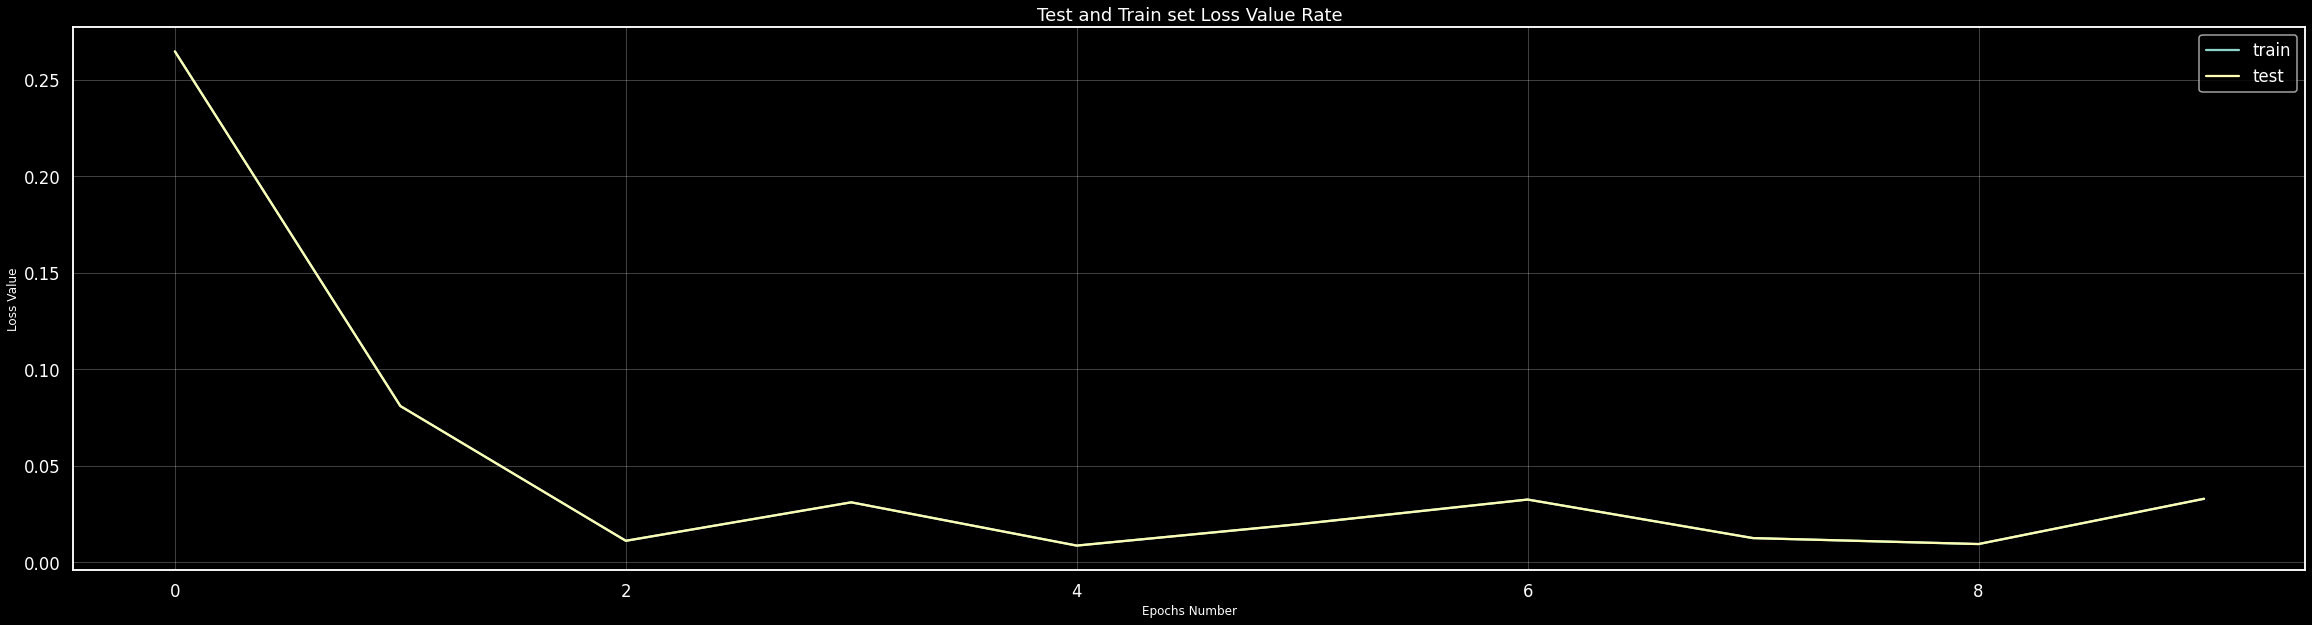

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Visualisation of loss values for every traing epoch
fg, ax = plt.subplots(figsize=(40, 10))
plt.title("Test and Train set Loss Value Rate")
plt.xlabel('Epochs Number', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
sb.lineplot(data=val_loss, label='train')
sb.lineplot(data=val_loss, label='test')

exportModel = True #@param {type:"boolean"}

# Export Model
if exportModel:
  fileName = f"{coinTicker.split('-')[0]}-{modelType}.h5"
  exportFolderPath = "models" #@param {type:"string"} 
  if len(exportFolderPath) > 0 and not exportFolderPath.endswith('/'):
    exportFolderPath += '/'
  filePath = f'{exportFolderPath if len(exportFolderPath) > 0 else ""}{fileName}'

  if onColab:
    if onDrive:
      filePath = f'/content/drive/My Drive/{filePath}'
      model.save(filePath)
      print(f"SUCCESSFULL EXPORTED to [{filePath}]")
    else:
      model.save(fileName)
      files.download(fileName)
      print(f"SUCCESSFULL EXPORTED to [{fileName}]")
  else:
    BASE_DIR = os.getcwd()
    filePath = os.path.join(BASE_DIR, filePath)
    model.save(filePath, encoding='utf-8', index=False)
    print(f"SUCCESSFULL EXPORTED to [{filePath}]")

#### Model Prediction
*Using the LSTM model to predict Train / Test values*


In [ ]:
# Prediction process is performed for Train dataset
trainPredict = model.predict(trainX)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[2]))

# Prediction process is performed for Test dataset
testPredict = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))

# Column index offset
offset = -(len(data.columns)-1)

# Trains dataset inverts scaling for training
trainPredict = np.concatenate((trainPredict, trainX[:, offset:]), axis=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = trainPredict[:,0]

# Test dataset inverts scaling for forecasting
testPredict = np.concatenate((testPredict, testX[:, offset:]), axis=1)
testPredict = scaler.inverse_transform(testPredict)
testPredict = testPredict[:,0]

# invert scaling for actual values
testReal = testY.reshape((len(testY), 1))
testReal = np.concatenate((testReal, testX[:, offset:]), axis=1)
testReal = scaler.inverse_transform(testReal)
testReal = testReal[:,0]

# invert scaling for actual values
trainReal = trainY.reshape((len(trainY), 1))
trainReal = np.concatenate((trainReal, trainX[:, offset:]), axis=1)
trainReal = scaler.inverse_transform(trainReal)
trainReal = trainReal[:,0]


# Model Evaluation
trainMetrics = {
    'RMSE': sqrt(mean_squared_error(trainReal,trainPredict)),
    'MSE': mean_squared_error(trainReal,trainPredict),
    'MAE': mean_absolute_error(trainReal,trainPredict),
    'EV': explained_variance_score(trainReal, trainPredict),
    'R2':  r2_score(trainReal, trainPredict),
    'MGD':  mean_gamma_deviance(trainReal, trainPredict),
    'MPD':  mean_poisson_deviance(trainReal, trainPredict),
}
testMetrics = {
    'RMSE': sqrt(mean_squared_error(testReal,testPredict)),
    'MSE': mean_squared_error(testReal,testPredict),
    'MAE': mean_absolute_error(testReal,testPredict),
    'EV': explained_variance_score(testReal, testPredict),
    'R2':  r2_score(testReal, testPredict),
    'MGD':  mean_gamma_deviance(testReal, testPredict),
    'MPD':   mean_poisson_deviance(testReal, testPredict),
}

# Compile/Export Metrics
metrics = {}
metrics[modelType] = {
  'TRAIN':trainMetrics,
  'TEST':testMetrics
}

exportJSON = True #@param {type:"boolean"}

# Export to CSV
if exportJSON:
  allMetrics = pd.DataFrame.from_dict(metrics,orient='columns')
  
  fileName = f"{modelType}_metrics.json"
  exportFolderPath = "metrics" #@param {type:"string"} 
  if len(exportFolderPath) > 0 and not exportFolderPath.endswith('/'):
    exportFolderPath += '/'
  filePath = f'{exportFolderPath if len(exportFolderPath) > 0 else ""}{fileName}'

  if onColab:
    if onDrive:
      filePath = f'/content/drive/My Drive/{filePath}'
      allMetrics.to_json(filePath, orient='columns')
      print(f"SUCCESSFULLY EXPORTED to [{filePath}]")
    else:
      allMetrics.to_json(fileName, orient='columns')
      files.download(fileName)
      print(f"SUCCESSFULLY EXPORTED to [{fileName}]")

  else:
    BASE_DIR = os.getcwd()
    filePath = os.path.join(BASE_DIR, filePath)
    allMetrics.to_json(filePath, orient='columns')
    print(f"SUCCESSFULLY EXPORTED to [{filePath}]")


# Display summary sorted by R-squared (R2) in descending order
pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                            for i in metrics.keys() 
                            for j in metrics[i].keys()},
                        orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUCCESSFULLY EXPORTED to [multiLSTM_metrics.json]


TYPE                RMSE          MSE      MAE   EV   R2  MGD    MPD
multiLSTM TRAIN   555.21   308,259.08   437.61 0.98 0.97 0.04  58.69
          TEST  2,364.27 5,589,784.38 2,197.77 1.00 0.97 0.00 130.64

##### Metrics Summary Import
*Compare and export the model metrics*

In [ ]:
importMetrics = False #@param {type:"boolean"}

if importMetrics:
  fileName = f"{modelType}_metrics.json"
  importFolderPath = "metrics" #@param {type:"string"} 

  if onColab:
    if onDrive:
      importFolderPath = f'/content/drive/My Drive/{importFolderPath if len(importFolderPath) > 0 else ""}'
    else:
      importFolderPath = f"/content/{importFolderPath if len(importFolderPath) > 0 else ''}"
  else:
    BASE_DIR = os.getcwd()
    importFolderPath = os.path.join(BASE_DIR, f"{importFolderPath if len(importFolderPath) > 0 else ''}")
  filePath = f'{importFolderPath}{fileName}'

  # Import CSV 
  try:
    sm = pd.read_json(filePath, orient="columns")
    # Display summary sorted by R-squared (R2) in descending order
    pd.DataFrame.from_dict({(i,j): sm[i][j] 
                              for i in sm.keys() 
                              for j in sm[i].keys()},
                          orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)
  except FileNotFoundError:
      print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

#### Prediction Comparison
*Compare the actual vs predicted value*

,CLOSE_real,CLOSE_pred
DATE,,
2017-01-01,998.33,619.67
2017-01-02,"1,021.75",591.53
2017-01-03,"1,043.84",607.51
2017-01-04,"1,154.73",599.70
2017-01-05,"1,013.38",512.74
...,...,...
2022-04-15,"40,553.46","42,466.28"
2022-04-16,"40,424.48","42,302.39"
2022-04-17,"39,716.95","42,312.37"


Text(0.5, 1.0, 'BTC-USD Prediction Comparison')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Valuation in USD')

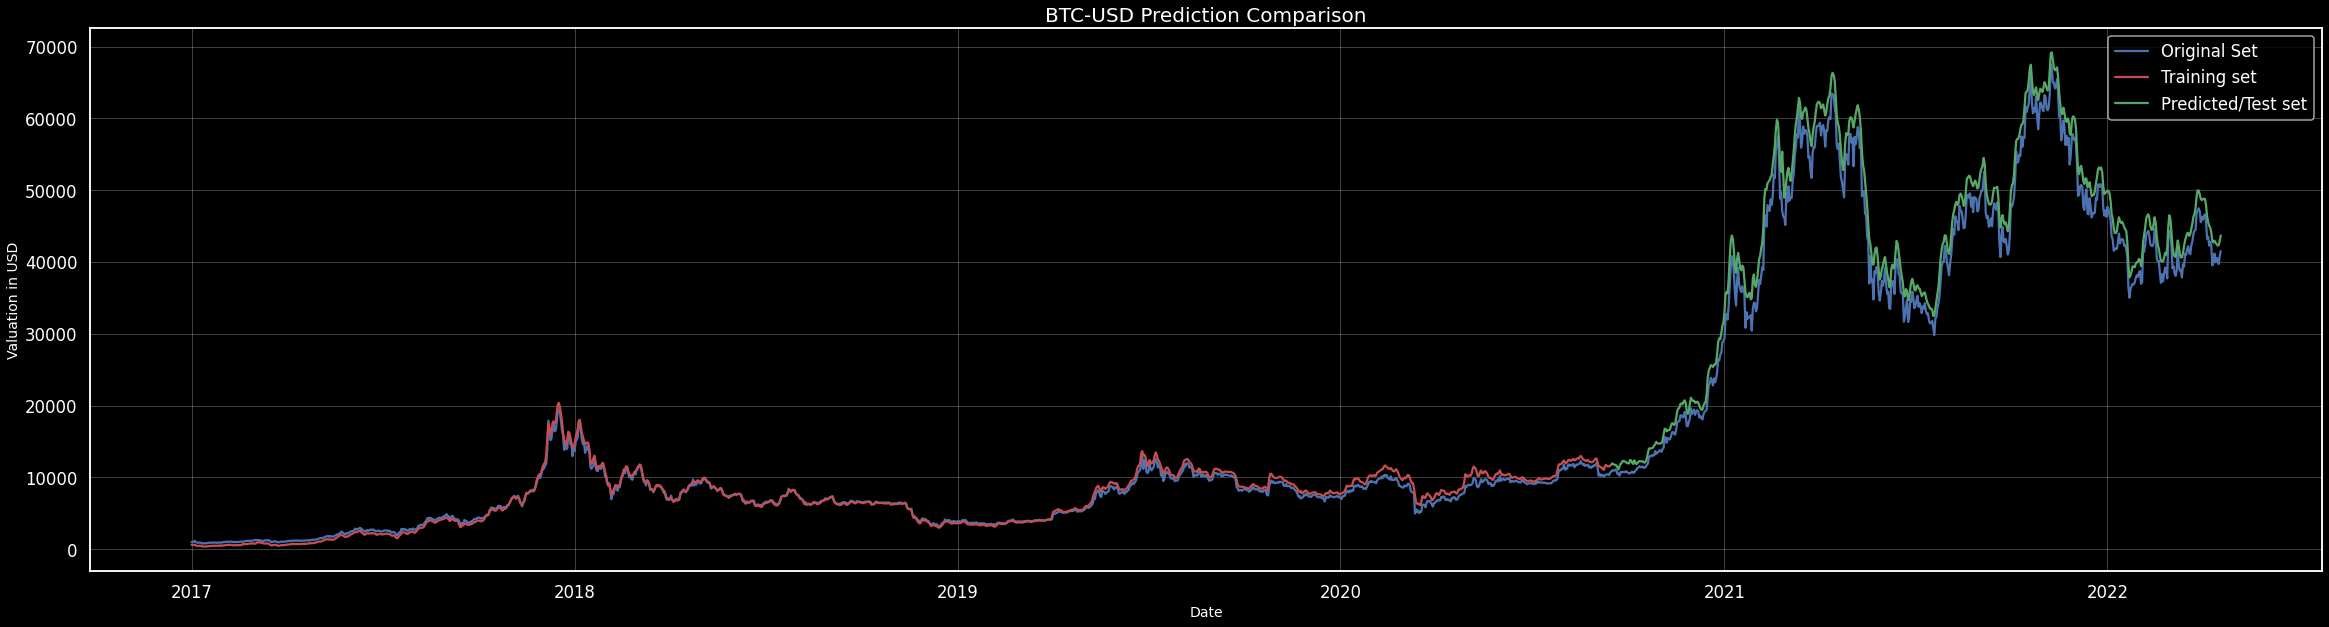

In [ ]:
showDataframe = True #@param {type:"boolean"}
showTimeRange = False #@param {type:"boolean"}

responseCol = 'CLOSE'

realData = deepcopy(data).reset_index()
realData.index.names = ['idx']
predictionData = pd.DataFrame(data=np.append(trainPredict, testPredict), columns=[responseCol])
predictionData.index.names = ['idx']

responseData = pd.merge(realData[['DATE', responseCol]], predictionData, on="idx", how='inner' , suffixes=('_real', '_pred'))
responseData = responseData.reset_index().drop(['idx'], axis=1).set_index('DATE')
if showDataframe:
  responseData

# Visualisation of LTSM prediction
if showTimeRange:
  fig = px.line(responseData, x=responseData.index, y=responseData.columns, title=f'{coinTicker} Prediction Comparison')
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
else:
  fg = plt.figure(figsize=(40, 10))
  sb.lineplot(data=responseData, y=responseData[f"{responseCol}_real"], color='b', x="DATE", label='Original Set')
  sb.lineplot(data=responseData, y=responseData[f"{responseCol}_pred"][0:len(trainPredict)-1], color='r' , x="DATE", label='Training set')
  sb.lineplot(data=responseData, y=responseData[f"{responseCol}_pred"][len(trainPredict)-1:len(responseData)], color='g', x="DATE", label='Predicted/Test set')
  plt.title(f'{coinTicker} Prediction Comparison', fontsize=20);
  plt.xlabel("Date", fontsize=14)
  plt.ylabel("Valuation in USD", fontsize=14)

  # plt.plot(responseData[f"{responseCol}_real"], 'b', label='Original Set')
  # plt.plot(responseData[f"{responseCol}_pred"][0:len(trainPredict)-1], 'r' , label='Training set')
  # plt.plot(responseData[f"{responseCol}_pred"][len(trainPredict)-1:len(responseData)], 'g' , label='Predicted/Test set')


## Model Evaluation

🔬 Evaluates the accuracy & efficacy of the prediction models

---

### Compilation Model Metrics
*Merge summary metrics*

*References*
* [Import & Concat multiple CSV](https://stackoverflow.com/a/55436079)


In [ ]:
import glob

combineMetrics = True #@param {type:"boolean"}

if combineMetrics:
  
  importFolderPath = "metrics" #@param {type:"string"}
  if len(importFolderPath) > 0 and not importFolderPath.endswith('/'):
    importFolderPath += '/'

  if onColab:
    if onDrive:
      importFolderPath = f'/content/drive/My Drive/{importFolderPath if len(importFolderPath) > 0 else ""}'
    else:
      importFolderPath = f"/content/{importFolderPath if len(importFolderPath) > 0 else ''}"
  filesPath = f'{importFolderPath}*.json'

  try:
    allMetrics = []
    for f in glob.glob(filesPath):
      sm = pd.read_json(f, orient="columns")
      allMetrics.append(sm)

    if len(allMetrics):
      # Fetch all files from folder path
      print(f"SUCCESSFULLY IMPORTED from [{filesPath}]")

      sm = pd.concat(allMetrics, axis=1)
      # Display summary sorted by R-squared (R2) in descending order
      pd.DataFrame.from_dict({(i,j): sm[i][j] 
                                for i in sm.keys() 
                                for j in sm[i].keys()},
                            orient='index').rename_axis("TYPE", axis=1)
  except FileNotFoundError:
    print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

SUCCESSFULLY IMPORTED from [/content/*.json]


TYPE                RMSE          MSE      MAE   EV   R2  MGD    MPD
multiLSTM TEST  2,364.27 5,589,784.38 2,197.77 1.00 0.97 0.00 130.64
          TRAIN   555.21   308,259.08   437.61 0.98 0.97 0.04  58.69

---

<p align="center" style="font-style:italic;">END OF NOTEBOOK</p>

<div style="display:flex; flex-direction:row; justify-content:space-between">
    <a href="./2_UnivariateForecast.ipynb" target="_blank">Univariate Forecast</a>
    <a href="./README.md" target="_blank">Project Overview</a>
</div>